## Digit Recognition using a Convolutional Neural Network
Student: Luca Cotter

Most code borrowed from https://github.com/iamkrut/MNIST_handwriting_classification with a few corrections (method of calculating percent accuracy, line 128, and visualizing final results, lines 132-138). Ran this code on both my laptop (MacBook Pro) and my desktop (included an NVIDIA 1080). The performance with the graphics card seems to be nearly 10x that of my laptop.

In [1]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from model import Model
import numpy as np

In [2]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        
        # RelU function is a piecewise linear function that outputs the input directly if is positive i.e. > 0, 
        # otherwise, it will output zero.
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # Perform fist convolution
        x = self.conv_1(x)
        
        # Apply the rectified linear activation function: a piecewise linear function that will output the input 
        # directly if it is positive, otherwise, it will output zero. 
        x = self.relu(x)
        
        # Apply a 2D max pooling over an input signal composed of several input planes.
        # Take the max of the region from the input overlapped by the kernel.
        # In this case, the kernel is 2 x 2 and the stride is 2 so there will be 
        # a reduction by a factor of 2. Input dimensions of the data matrix will be
        # reduced by a factor of 2.
        x = self.max_pool2d(x)
        
        # Perform 2nd convolution
        x = self.conv_2(x)
        
        
        # Apply rectified linear activiation function again.
        x = self.relu(x)
        
        # Apply max_pool2d again and reduce by factor of 2.
        x = self.max_pool2d(x)
        
        # Reshape from batch size x 64 x 7 x 7 to batch size x 3136 to feed into the neural net
        # (i.e. flatten the convoluted data)
        x = x.reshape(x.size(0), -1)

        # Applies a linear transformation to the incoming data
        #  y = x * A' + b
        x = self.linear_1(x)
        
        # Apply rectified linear activiation function again.
        x = self.relu(x)
        
        # randomly drop out features (set them to zero during training)
        x = self.dropout(x)
        
        # Applies a linear transformation again to form final output vector
        # of 10 items.
        pred = self.linear_2(x)

        return pred

In [3]:
# set batch sizes for reading the data and performing the training, validation and testing
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_VAL = 32
BATCH_SIZE_TEST = 32

In [4]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

# Split the test set into a validation set and a test set
mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset, [int(0.9 * len(mnist_testset)), int(0.1 * len(mnist_testset))])

train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=BATCH_SIZE_VAL, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=BATCH_SIZE_TEST, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))


Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


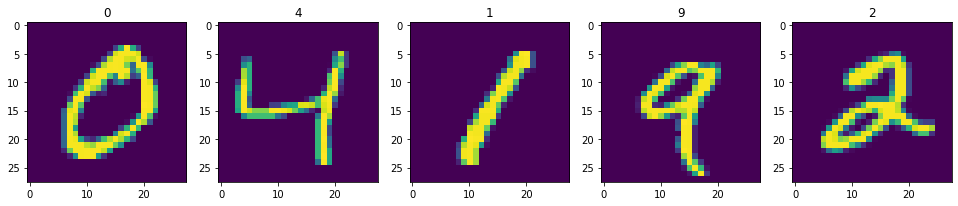

torch.Size([1, 28, 28])

In [5]:

# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    image, label = mnist_trainset[i]
    img = transforms.ToPILImage(mode='L')(image[0])
    fig.add_subplot(1, 6, i)
    plt.title(label)
    plt.imshow(img)
    
plt.show()
mnist_trainset[i][0].shape

In [6]:
# Create an instance of the Model class with which to train and optimize the neural net
model = Model()

# define the loss criterion
# Loss function tells us how good the model is predicting. Since we are dealing with multi class 
# classification we choose cross entropy as our loss function
criterion = torch.nn.CrossEntropyLoss()

# An optimizer ties the loss function and model parameters together by updating the model in response to the 
# output of the loss criterion. We will be using Adam as our optimizer with a learning rate of 0.001.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [7]:


if (torch.cuda.is_available()):
    print("Found cuda...")
    model.cuda()

no_epochs = 25  # original number of epochs was 100, but results didn't improve after 16
train_loss = list()
val_loss = list()
best_val_loss = 1

for epoch in range(no_epochs):

    # Set the model to train mode. This allows us to enable the dropout layer and also set the model in training mode.
    # The dropout layer will randomly drop certain features and help prevent overfitting
    model.train()
    
    # training
    total_train_loss = 0
    for itr, (image, label) in enumerate(train_dataloader):
        # images are generally BATCH_SIZE_TRAINING large except last batch
        
        # Check whether we have a graphics processor
        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        # Zero out the gradient
        optimizer.zero_grad()
    
        # predict a label for each image in the batch of images
        # returns a tensor of size batch_size_train x 10 (10 for digits 0 - 9)
        pred = model(image)

        # A loss function is a method of evaluating how well the model models the dataset.
        # The loss function will output a higher number if the predictions are off the actual 
        # target values whereas otherwise it will output a lower number.
        loss = criterion(pred, label)
        
        # add this loss to the total for the entire epoch
        total_train_loss += loss.item()

        # Calculate gradients
        loss.backward()
        
        # Perform parameter updates based on the current gradient
        # use Adam optimizer to modify the model parameters.
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    # validation
    model.eval()
    total = 0
    total_val_loss = 0
    for itr, (image_batch, label) in enumerate(val_dataloader):

        if (torch.cuda.is_available()):
            image_batch = image_batch.cuda()
            label = label.cuda()

        # pred.size should equal batch_size x 10
        pred = model(image_batch)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_valset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")


Found cuda...

Epoch: 1/25, Train Loss: 0.27632406, Val Loss: 0.05029048, Val Accuracy: 0.98255556
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.05029048

Epoch: 2/25, Train Loss: 0.09556314, Val Loss: 0.03989276, Val Accuracy: 0.98622222
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.03989276

Epoch: 3/25, Train Loss: 0.07325335, Val Loss: 0.03270714, Val Accuracy: 0.98888889
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.03270714

Epoch: 4/25, Train Loss: 0.05779018, Val Loss: 0.02678911, Val Accuracy: 0.98955556
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.02678911

Epoch: 5/25, Train Loss: 0.05140343, Val Loss: 0.02124675, Val Accuracy: 0.99277778
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.02124675

Epoch: 6/25, Train Loss: 0.04227367, Val Loss: 0.02341990, Val Accuracy: 0.99255556

Epoch: 7/25, Train Loss: 0.03763563, Val Loss: 0.02635491, Val Accuracy: 0.

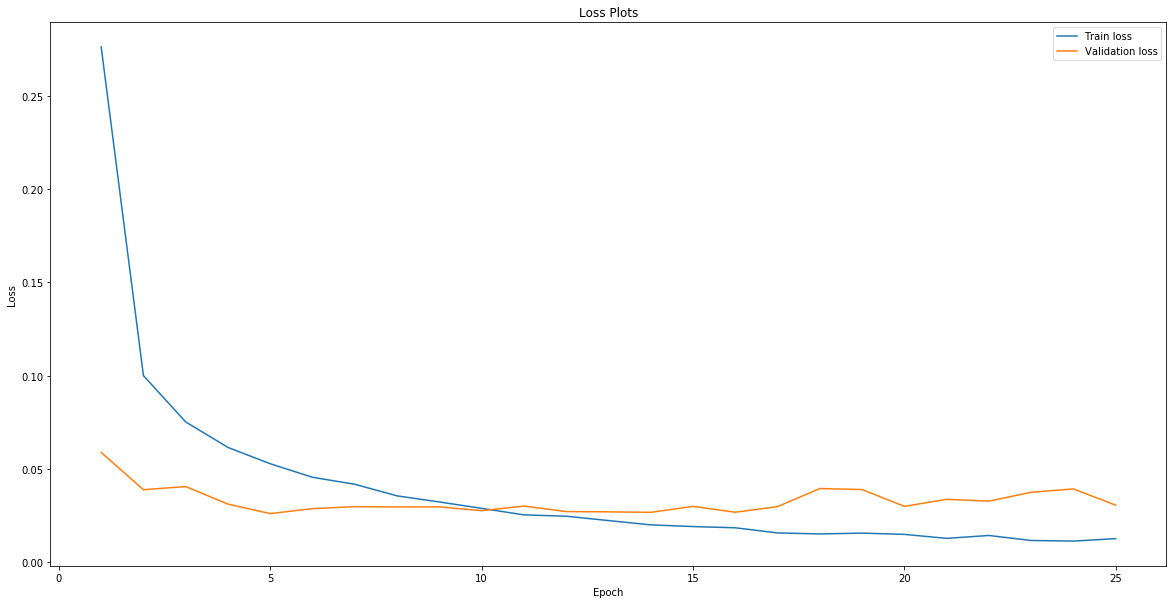

In [8]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [9]:
# test model
model.load_state_dict(torch.load("model.dth"))
model.eval()

results = list()
total = 0
num_images = 0

for itr, (image, label) in enumerate(test_dataloader):
    #print(itr, image.shape, label.shape)
    # generally image.shape is 32, 1, 28, 28 (i.e. 32 images) 
    # but since the last batch only has 8 images in it, it has image.shape = 8, 1, 28, 28
    num_images += image.shape[0]
    # image generally has 32 images per batch
    if (torch.cuda.is_available()):
        image = image.cuda()
        label = label.cuda()
        
    # pred.shape will be 32, 10. One length 10 vector per image
    pred = model(image)
    pred = torch.nn.functional.softmax(pred, dim=1)

    # Loop through the batch of images one image at a time
    # usually BATCH_SIZE_TEST number of images (i.e. 32)
    for i, p in enumerate(pred):
        # check whether actual label matches the predicted label
        if label[i] == torch.max(p.data, 0)[1]:
            total = total + 1
            results.append((image[i], torch.max(p.data, 0)[1]))

test_accuracy = total / num_images
print('Test accuracy {:.8f}'.format(test_accuracy))

Test accuracy 0.99200000


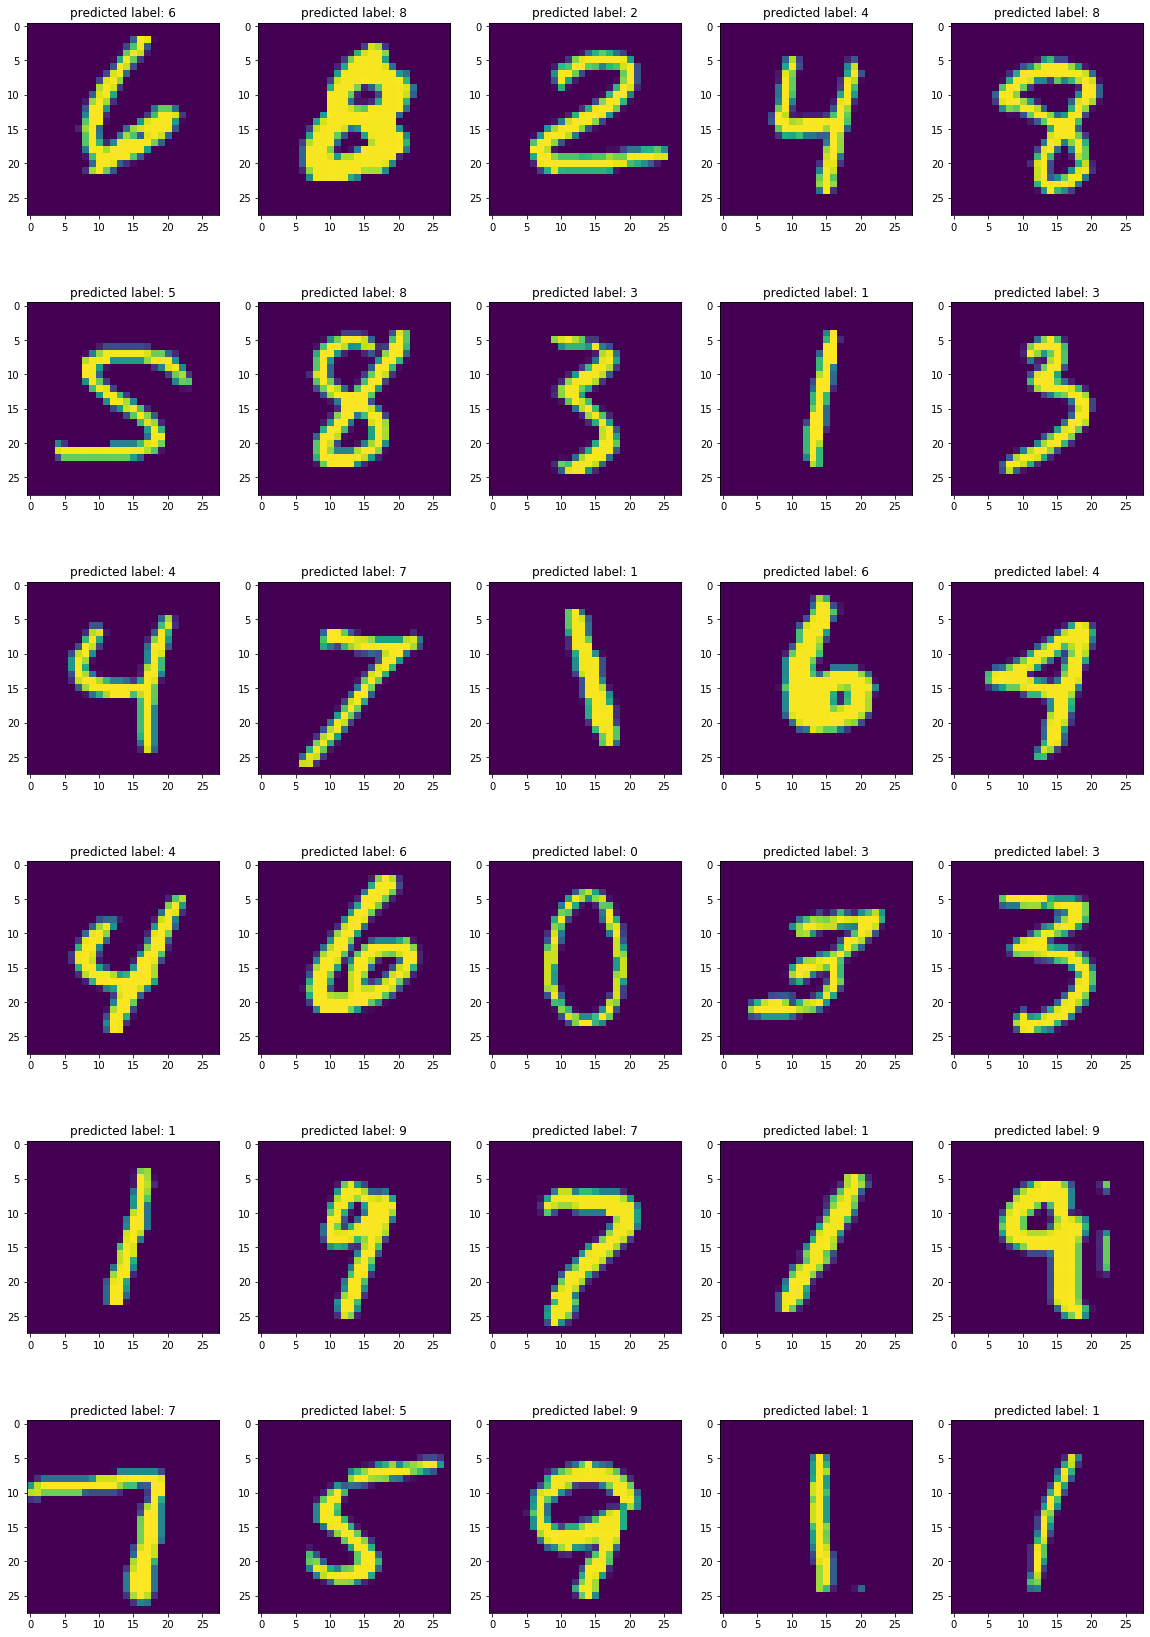

In [10]:
# visualize results
fig=plt.figure(figsize=(20, 30))
for i in range(1, 31):
    image, label = results[i]
    image = image.cpu()
    img = transforms.ToPILImage(mode='L')(image)
    fig.add_subplot(6, 5, i)
    plt.title("predicted label: " + str(label.data.cpu().item()))
    plt.imshow(img)
plt.show()